# Table of contents

1. [Load the dataset](#load_the_dataset)
2. [Split the dataset](#split_the_dataset)
3. [Fitting the recommender](#fitting)
4. [Sequential evaluation](#seq_evaluation)  
    4.1 [Evaluation with sequentially revaeled user profiles](#eval_seq_rev)  
    4.2 [Evaluation with "static" user profiles](#eval_static)  
5. [Analysis of next-item recommendation](#next-item)  
    5.1 [Evaluation with different recommendation list lengths](#next-item_list_length)  
    5.2 [Evaluation with different user profile lengths](#next-item_profile_length)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from util.data_utils import create_seq_db_filter_top_k, sequences_to_spfm_format
from util.split import last_session_out_split
from util.metrics import precision, recall, mrr
from util import evaluation
from recommenders.KNNRecommender import KNNRecommender

In [3]:
import datetime

In [4]:
def get_test_sequences(test_data, given_k):
    # we can run evaluation only over sequences longer than abs(LAST_K)
    test_sequences = test_data.loc[test_data['sequence'].map(len) > abs(given_k), 'sequence'].values
    return test_sequences

<a id='load_the_dataset'></a>

# 1. Load the dataset

For this hands-on session we will use a dataset of user-listening sessions crawled from [last.fm](https://www.last.fm/). In detail, we will use a subset of the following dataset:

* 30Music listening and playlists dataset, Turrin et al., ACM RecSys 2015 ([paper](https://home.deib.polimi.it/pagano/portfolio/papers/30Musiclisteningandplaylistsdataset.pdf))

In [6]:
dataset_path = 'datasets/sessions_sample_10.csv'

# for the sake of speed, let's keep only the top-1k most popular items in the last month
dataset = create_seq_db_filter_top_k(path=dataset_path, topk=1000, last_months=1) 

/home/juno/Downloads/sars_tutorial-master/util/data_utils.py:24: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  aggregated = groups['item_id'].agg({'sequence': lambda x: list(map(str, x))})


Let's see at how the dataset looks like

In [7]:
dataset.head()

,session_id,sequence,ts,user_id
0,357,"[793, 3489]",1421003874,4296
1,359,[1762],1421018535,4296
2,394,[1256],1421007470,30980
3,4127,"[1948, 1364, 2060, 1115, 6488, 2060]",1421416896,28117
4,6400,"[687, 1394]",1420807778,35247


Let's show some statistics about the dataset

In [8]:
from collections import Counter
cnt = Counter()
dataset.sequence.map(cnt.update);

In [9]:
sequence_length = dataset.sequence.map(len).values
n_sessions_per_user = dataset.groupby('user_id').size()

print('Number of items: {}'.format(len(cnt)))
print('Number of users: {}'.format(dataset.user_id.nunique()))
print('Number of sessions: {}'.format(len(dataset)) )

print('\nSession length:\n\tAverage: {:.2f}\n\tMedian: {}\n\tMin: {}\n\tMax: {}'.format(
    sequence_length.mean(), 
    np.quantile(sequence_length, 0.5), 
    sequence_length.min(), 
    sequence_length.max()))

print('Sessions per user:\n\tAverage: {:.2f}\n\tMedian: {}\n\tMin: {}\n\tMax: {}'.format(
    n_sessions_per_user.mean(), 
    np.quantile(n_sessions_per_user, 0.5), 
    n_sessions_per_user.min(), 
    n_sessions_per_user.max()))

Number of items: 1000
Number of users: 4165
Number of sessions: 6766

Session length:
	Average: 4.29
	Median: 3.0
	Min: 1
	Max: 148
Sessions per user:
	Average: 1.62
	Median: 1.0
	Min: 1
	Max: 13


In [10]:
print('Most popular items: {}'.format(cnt.most_common(5)))

Most popular items: [('443', 207), ('1065', 155), ('67', 146), ('2308', 138), ('658', 131)]


<a id='split_the_dataset'></a>

# 2. Split the dataset

For simplicity, let's split the dataset by assigning the **last session** of every user to the **test set**, and **all the previous** ones to the **training set**.

In [11]:
train_data, test_data = last_session_out_split(dataset)
print("Train sessions: {} - Test sessions: {}".format(len(train_data), len(test_data)))

Train sessions: 2601 - Test sessions: 4165


<a id='fitting'></a>

# 3. Fitting the recommender

Here we fit the recommedation algorithm over the sessions in the training set.  

The class `KNNRecommender` takes the following initialization hyper-parameters:
- `model`: One among the following KNN models:
    - `iknn`: ItemKNN, item-to-item KNN based on the *last* item in the session to determine the items to be recommended.
    - `sknn`: SessionKNN, compares the *entire* current session with the past sessions in the training data to determine the items to be recommended.
    - `v-sknn`: VMSessionKNN, use linearly decayed real-valued vectors to encode the current session, then compares the current session with the past sessions in the training data using the dot-product to determine the items to be recommended.
    - `s-sknn`: SeqSessionKNN, this variant also puts more weight on elements that appear later in the session by using a custom scoring function (see the paper by Ludewng and Jannach).
    - `sf-sknn`: SeqFilterSessionKNN, this variant also puts more weight on elements that appear later in the session in a more restrictive way by using a custom scoring function (see the paper by Ludewng and Jannach).

- param `init_args`: The model initialization arguments. See the following initializations or check `util.knn` for more details on each model:
    - `iknn`: ItemKNN(n_sims=100, lmbd=20, alpha=0.5)
    - `sknn`: SessionKNN(k, sample_size=500, sampling='recent', similarity='jaccard', remind=False, pop_boost=0)
    - `v-sknn`: VMSessionKNN(k, sample_size=1000, sampling='recent', similarity='cosine', weighting='div',
         dwelling_time=False, last_n_days=None, last_n_clicks=None, extend=False, weighting_score='div_score',
         weighting_time=False, normalize=True)
    - `s-knn`: SeqSessionKNN(k, sample_size=1000, sampling='recent', similarity='jaccard', weighting='div',
        remind=False, pop_boost=0, extend=False, normalize=True)
    - `sf-sknn`: SeqFilterSessionKNN(k, sample_size=1000, sampling='recent', similarity='jaccard', remind=False, pop_boost=0,extend=False, normalize=True)


In [12]:
recommender = KNNRecommender(model='sknn', k=10)
recommender.fit(train_data)

2019-12-10 16:37:54,236 - INFO - Converting training data to GRU4Rec format
2019-12-10 16:37:54,257 - INFO - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2019-12-10 16:37:54,258 - INFO - NumExpr defaulting to 8 threads.
2019-12-10 16:37:54,260 - INFO - Training started
2019-12-10 16:37:54,307 - INFO - Training completed


<a id='seq_evaluation'></a>


# 4. Sequential evaluation

In the evaluation of sequence-aware recommenders, each sequence in the test set is split into:
- the _user profile_, used to compute recommendations, is composed by the first *k* events in the sequence;
- the _ground truth_, used for performance evaluation, is composed by the remainder of the sequence.

In the cells below, you can control the dimension of the _user profile_ by assigning a **positive** value to `GIVEN_K`, which correspond to the number of events from the beginning of the sequence that will be assigned to the initial user profile. This ensures that each user profile in the test set will have exactly the same initial size, but the size of the ground truth will change for every sequence.

Alternatively, by assigning a **negative** value to `GIVEN_K`, you will set the initial size of the _ground truth_. In this way the _ground truth_ will have the same size for all sequences, but the dimension of the user profile will differ.

In [13]:
METRICS = {'precision':precision, 
           'recall':recall,
           'mrr': mrr}
TOPN = 10 # length of the recommendation list

<a id='eval_seq_rev'></a>

## 4.1 Evaluation with sequentially revealed user-profiles

Here we evaluate the quality of the recommendations in a setting in which user profiles are revealed _sequentially_.

The _user profile_ starts from the first `GIVEN_K` events (or, alternatively, from the last `-GIVEN_K` events if `GIVEN_K<0`).  
The recommendations are evaluated against the next `LOOK_AHEAD` events (the _ground truth_).  
The _user profile_ is next expanded to the next `STEP` events, the ground truth is scrolled forward accordingly, and the evaluation continues until the sequence ends.

In typical **next-item recommendation**, we start with `GIVEN_K=1`, generate a set of **alternatives** that will evaluated against the next event in the sequence (`LOOK_AHEAD=1`), move forward of one step (`STEP=1`) and repeat until the sequence ends.

You can set the `LOOK_AHEAD='all'` to see what happens if you had to recommend a **whole sequence** instead of a set of a set of alternatives to a user.

NOTE: Metrics are averaged over each sequence first, then averaged over all test sequences.

** (TODO) Try out with different evaluation settings to see how the recommandation quality changes. **


![](gifs/sequential_eval.gif)

In [14]:
# GIVEN_K=1, LOOK_AHEAD=1, STEP=1 corresponds to the classical next-item evaluation
GIVEN_K = 1
LOOK_AHEAD = 1
STEP = 1

In [15]:
test_sequences = get_test_sequences(test_data, GIVEN_K)
print('{} sequences available for evaluation'.format(len(test_sequences)))

results = evaluation.sequential_evaluation(recommender,
                                           test_sequences=test_sequences,
                                           given_k=GIVEN_K,
                                           look_ahead=LOOK_AHEAD,
                                           evaluation_functions=METRICS.values(),
                                           top_n=TOPN,
                                           scroll=True,  # scrolling averages metrics over all profile lengths
                                           step=STEP)

  0%|          | 12/2891 [00:00<00:30, 95.52it/s]

2891 sequences available for evaluation


100%|██████████| 2891/2891 [01:41<00:00, 28.47it/s]


In [16]:
print('Sequential evaluation (GIVEN_K={}, LOOK_AHEAD={}, STEP={})'.format(GIVEN_K, LOOK_AHEAD, STEP))
for mname, mvalue in zip(METRICS.keys(), results):
    print('\t{}@{}: {:.4f}'.format(mname, TOPN, mvalue))

Sequential evaluation (GIVEN_K=1, LOOK_AHEAD=1, STEP=1)
	precision@10: 0.0423
	recall@10: 0.4227
	mrr@10: 0.1596


<a id='eval_static'></a>

## 4.2 Evaluation with "static" user-profiles

Here we evaluate the quality of the recommendations in a setting in which user profiles are instead _static_.

The _user profile_ starts from the first `GIVEN_K` events (or, alternatively, from the last `-GIVEN_K` events if `GIVEN_K<0`).  
The recommendations are evaluated against the next `LOOK_AHEAD` events (the _ground truth_).  

The user profile is *not extended* and the ground truth *doesn't move forward*.
This allows to obtain "snapshots" of the recommendation performance for different user profile and ground truth lenghts.

Also here you can set the `LOOK_AHEAD='all'` to see what happens if you had to recommend a **whole sequence** instead of a set of a set of alternatives to a user.

**(TODO) Try out with different evaluation settings to see how the recommandation quality changes.**

In [17]:
GIVEN_K = 1
LOOK_AHEAD = 1
STEP=1

In [18]:
test_sequences = get_test_sequences(test_data, GIVEN_K)
print('{} sequences available for evaluation'.format(len(test_sequences)))

results = evaluation.sequential_evaluation(recommender,
                                           test_sequences=test_sequences,
                                           given_k=GIVEN_K,
                                           look_ahead=LOOK_AHEAD,
                                           evaluation_functions=METRICS.values(),
                                           top_n=TOPN,
                                           scroll=False  # notice that scrolling is disabled!
                                          )  

  1%|▏         | 42/2891 [00:00<00:06, 412.39it/s]

2891 sequences available for evaluation


100%|██████████| 2891/2891 [00:07<00:00, 397.77it/s]


In [19]:
print('Sequential evaluation (GIVEN_K={}, LOOK_AHEAD={}, STEP={})'.format(GIVEN_K, LOOK_AHEAD, STEP))
for mname, mvalue in zip(METRICS.keys(), results):
    print('\t{}@{}: {:.4f}'.format(mname, TOPN, mvalue))

Sequential evaluation (GIVEN_K=1, LOOK_AHEAD=1, STEP=1)
	precision@10: 0.0404
	recall@10: 0.4037
	mrr@10: 0.1598


<a id='next-item'></a>

## 5. Analysis of next-item recommendation

Here we propose to analyse the performance of the recommender system in the scenario of *next-item recommendation* over the following dimensions:

* the *length* of the **recommendation list**, and
* the *length* of the **user profile**.

NOTE: This evaluation is by no means exhaustive, as different the hyper-parameters of the recommendation algorithm should be *carefully tuned* before drawing any conclusions. Unfortunately, given the time constraints for this tutorial, we had to leave hyper-parameter tuning out. A very useful reference about careful evaluation of (session-based) recommenders can be found at:

*  Evaluation of Session-based Recommendation Algorithms, Ludewig and Jannach, 2018 ([paper](https://arxiv.org/abs/1803.09587))

<a id='next-item_list_length'></a>

### 5.1 Evaluation for different recommendation list lengths

In [20]:
GIVEN_K = 1
LOOK_AHEAD = 1
STEP = 1
topn_list = [1, 5, 10, 20, 50, 100]

In [21]:
# ensure that all sequences have the same minimum length 
test_sequences = get_test_sequences(test_data, GIVEN_K)
print('{} sequences available for evaluation'.format(len(test_sequences)))

2891 sequences available for evaluation


In [22]:
res_list = []

for topn in topn_list:
    print('Evaluating recommendation lists with length: {}'.format(topn))
    res_tmp = evaluation.sequential_evaluation(recommender,
                                               test_sequences=test_sequences,
                                               given_k=GIVEN_K,
                                               look_ahead=LOOK_AHEAD,
                                               evaluation_functions=METRICS.values(),
                                               top_n=topn,
                                               scroll=True,  # here we average over all profile lengths
                                               step=STEP)
    mvalues = list(zip(METRICS.keys(), res_tmp))
    res_list.append((topn, mvalues))

  0%|          | 12/2891 [00:00<00:29, 97.68it/s]

Evaluating recommendation lists with length: 1


  0%|          | 12/2891 [00:00<00:29, 98.87it/s]

Evaluating recommendation lists with length: 5


  0%|          | 12/2891 [00:00<00:28, 99.53it/s]

Evaluating recommendation lists with length: 10


  0%|          | 12/2891 [00:00<00:28, 100.01it/s]

Evaluating recommendation lists with length: 20


  0%|          | 12/2891 [00:00<00:28, 99.37it/s]

Evaluating recommendation lists with length: 50


  0%|          | 12/2891 [00:00<00:35, 80.39it/s]

Evaluating recommendation lists with length: 100


100%|██████████| 2891/2891 [01:42<00:00, 28.09it/s]


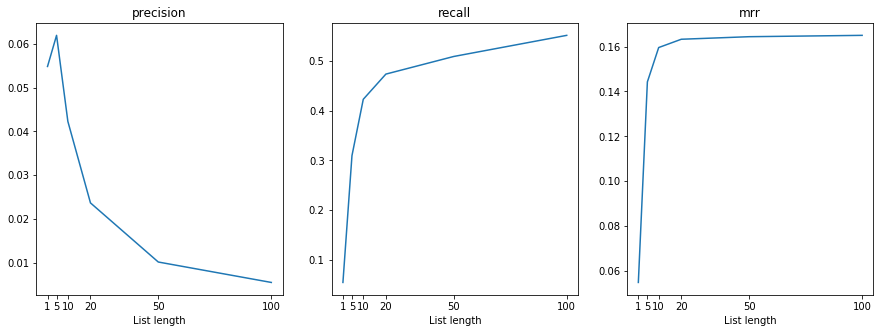

In [23]:
# show separate plots per metric
fig, axes = plt.subplots(nrows=1, ncols=len(METRICS), figsize=(15,5))
res_list_t = list(zip(*res_list))
for midx, metric in enumerate(METRICS):
    mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
    ax = axes[midx]
    ax.plot(topn_list, mvalues)
    ax.set_title(metric)
    ax.set_xticks(topn_list)
    ax.set_xlabel('List length')

<a id='next-item_profile_length'></a>

### 5.2 Evaluation for different user profile lengths

In [24]:
given_k_list = [1, 2, 3, 4]
LOOK_AHEAD = 1
STEP = 1
TOPN = 10

In [25]:
# ensure that all sequences have the same minimum length 
test_sequences = get_test_sequences(test_data, max(given_k_list))
print('{} sequences available for evaluation'.format(len(test_sequences)))

res_list = []

for gk in given_k_list:
    print('Evaluating profiles having length: {}'.format(gk))
    res_tmp = evaluation.sequential_evaluation(recommender,
                                               test_sequences=test_sequences,
                                               given_k=gk,
                                               look_ahead=LOOK_AHEAD,
                                               evaluation_functions=METRICS.values(),
                                               top_n=TOPN,
                                               scroll=False,  # here we stop at each profile length
                                               step=STEP)
    mvalues = list(zip(METRICS.keys(), res_tmp))
    res_list.append((gk, mvalues))

  3%|▎         | 40/1165 [00:00<00:02, 388.81it/s]

1165 sequences available for evaluation
Evaluating profiles having length: 1


  3%|▎         | 31/1165 [00:00<00:03, 306.98it/s]

Evaluating profiles having length: 2


  2%|▏         | 26/1165 [00:00<00:04, 253.27it/s]

Evaluating profiles having length: 3


  2%|▏         | 22/1165 [00:00<00:05, 209.61it/s]

Evaluating profiles having length: 4


100%|██████████| 1165/1165 [00:05<00:00, 207.31it/s]


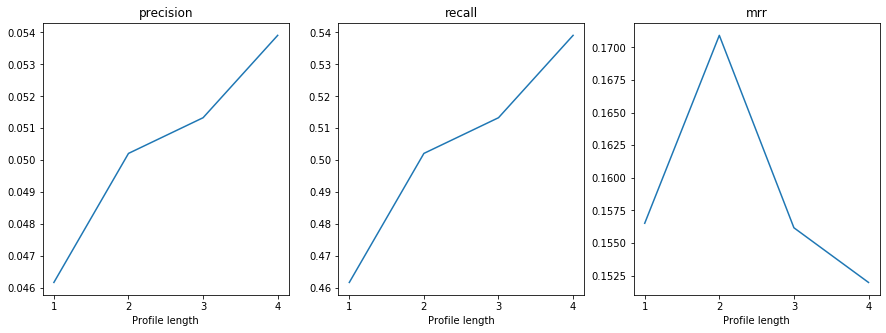

In [26]:
# show separate plots per metric
fig, axes = plt.subplots(nrows=1, ncols=len(METRICS), figsize=(15,5))
res_list_t = list(zip(*res_list))
for midx, metric in enumerate(METRICS):
    mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
    ax = axes[midx]
    ax.plot(given_k_list, mvalues)
    ax.set_title(metric)
    ax.set_xticks(given_k_list)
    ax.set_xlabel('Profile length')